# Embeddings and vector search in HuggingFace

## Resources 
 - [HF Tutorial Video # 42- Text Embeddings and Semantic search](https://www.youtube.com/watch?v=OATCgQtNX2o&list=PLo2EIpI_JMQvWfQndUesu0nPBAtZ9gP1o&index=42)

In [1]:
import transformers
import datasets
import torch

from transformers import AutoTokenizer, AutoModel

In [2]:
# The next two are for my diagramming. Nothing to do with HF
%load_ext nb_js_diagrammers
import iplantuml

## Per Token embeddings

BERT (_and maybe other encoder models_) produces one embedding per token. The code below (_taken from the HF video_) shows that the last-layer's hidden state is of shape `torch.size([3,9,384])` i.e., [ `num sentences`, `num tokens`, `embedding size`]. This represents one embedding-vector per token.

However, when we want to find vector simiarity or semantic-similarity between two sentences, we want an embedding per sentence. 

In [3]:
# Code from first slide on
# https://www.youtube.com/watch?v=OATCgQtNX2o&list=PLo2EIpI_JMQvWfQndUesu0nPBAtZ9gP1o&index=42
sentences = [
    "I took my dog for a walk",
    "Today is going to rain",
    "I took my cat for a walk"
]

# Previous examples used bert-uncased. but this is described as a model that maps sentences & paragraphs
# to a 384 dim vector space designed for semanic search or clustering. Still BERT based ?
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
model_ckpt = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Does AutoModel remove the final head like mentioned earlier? (What does it have anyway in this model ?)
model = AutoModel.from_pretrained(model_ckpt)

encoded_input = tokenizer(sentences, padding=True, return_tensors="pt")

with torch.no_grad():
    model_output = model(**encoded_input)

token_embeddings = model_output.last_hidden_state
print(f"Token Embedding shape: {token_embeddings.size()}")

Token Embedding shape: torch.Size([3, 9, 384])


## Pooling to get per-sentence embedding

He says use pooling to get the per-sentence embedding (_will need to scratch that a bit later_)
 - Use the embedding of the [CLS] token (_recall that this represents the entire input_) _The following code shows that the `[CLS]` token is indeed added as the first token, so we can take the vector for that ?_

In [19]:
tokenized_input = tokenizer(sentences, padding=True)
print(f"Tokenized input: {tokenized_input}")
print(f"Decoded first sentence → {tokenizer.decode(tokenized_input['input_ids'][0])}")

Tokenized input: {'input_ids': [[101, 1045, 2165, 2026, 3899, 2005, 1037, 3328, 102], [101, 2651, 2003, 2183, 2000, 4542, 102, 0, 0], [101, 1045, 2165, 2026, 4937, 2005, 1037, 3328, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}
Decoded first sentence → [CLS] i took my dog for a walk [SEP]


In [57]:
# Pooled output
import torch.nn.functional as F

def mean_pooling(model_output, attention_mask):
    #( NumSentences x NumTokens x VectorSize)
    token_embeddings = model_output.last_hidden_state
    
    # Don't include the padding tokens in the Avg. So use the attention-mask to 0 out those 
    # contributions
    #
    # Unsqueeze (See pyTorch.ipynb) adds a dimension to the end reshaping the tensor
    #   attention mask is a (NumSentences x NumTokens) shaped (since it is based on the input)
    #   unshaping(-1) makes it (NumSentences x NumTokens x 1)
    # Expand expands the dimension by duplicating stuff. So now the attention_mask is same size 
    #   as the token_embeddings which is (NumSentences x NumTokens x VectorSize)
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()    


    # input_mask_expanded.sum(1) sums along dim-1 (NumTokens)
    # and reduce the tensor to (NumSequences x VectorSize)
    # Basically sum the embeddings over Tokens and divide by mask-sum (these are usually just 
    # Sigma(numTokens))
    return torch.sum( token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

# Attention-mask is a [[], [], []] → List[[list per sentence]]
sentence_embeddings = mean_pooling(model_output, encoded_input["attention_mask"])

# normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
print(f"Sentence embeddings shape: {sentence_embeddings.size()}")

Sentence embeddings shape: torch.Size([3, 384])
tensor([[ 0.0095,  0.0274,  0.0853,  ...,  0.0229, -0.1072, -0.0176],
        [-0.0242,  0.0483,  0.1164,  ..., -0.0661, -0.0355,  0.0466],
        [ 0.0667,  0.0301,  0.0635,  ...,  0.0252, -0.1078, -0.0269]])


Once we have sentence encodings, we can check their cosine-similarity. The video uses `scikitlearn`. I know torch has builtin cosine similarity and cosine loss functions. So should be able to use that. The scikitlearn code is listed here (_there is no code to actually show the plot_).

```python
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

sentence_embeddings = sentence_embeddings.detach().numpy()

scores = np.zeros((sentence_embeddings.shape[0], sentence_embeddings.shape[0])

for idx in range(sentence_embeddings.shape[0]):
  scores[idx, :] = cosine_similarity([sentence_embeddings[idx]], sentence_embeddings)[0]
```

While scikit learn is good and all. I want to see if a all-pytorch implementation can be found. Googling lead me to [pytorch-BERT-sentence-similarity](https://www.kaggle.com/code/eriknovak/pytorch-bert-sentence-similarity) which explores sentence similarity in multiple ways. As a bonus also has matplotlib code for the comparison matrix.
 - `[CLS]` token's vector representation
 - Mean 
 - max-timeline

While the HF code example uses `model_output.last_hidden_state` (_of size (NumSentences x NumTokens x VectorSize)_) to get the embeddings, the link above uses `model_output[0]` and states that `model_output[1]` has the `[CLS]` embeddings meant for further training for the `NSP` objective. He then proceeds to say that we won't be using it but actually does by using `embeds[:, 0, :]` which, if you recall that the `[CLS]` token is the first one in the sentence, actually gets the `[CLS]` token's embedding. So what is in `model_output[1]` ?

> I am not making any attempt to refactor any of the code below.

In [58]:
# Visualization code from https://www.kaggle.com/code/eriknovak/pytorch-bert-sentence-similarity
import matplotlib.pyplot as plt
import numpy as np

def visualize(distances, figsize=(10, 5), titles=None):
    # get the number of columns
    ncols = len(distances)
    # create the subplot placeholders
    fig, ax = plt.subplots(ncols=ncols, figsize=figsize)
    
    for i in range(ncols):
        
        # get the axis in which we will draw the matrix
        axes = ax[i] if ncols > 1 else ax
        
        # get the i-th distance
        distance = distances[i]
        
        # create the heatmap
        axes.imshow(distance)
        
        # show the ticks
        axes.set_xticks(np.arange(distance.shape[0]))
        axes.set_yticks(np.arange(distance.shape[1]))
        
        # set the tick labels
        axes.set_xticklabels(np.arange(distance.shape[0]))
        axes.set_yticklabels(np.arange(distance.shape[1]))
        
        # set the values in the heatmap
        for j in range(distance.shape[0]):
            for k in range(distance.shape[1]):
                text = axes.text(k, j, str(round(distance[j, k], 3)),
                               ha="center", va="center", color="w")
        
        # set the title of the subplot
        title = titles[i] if titles and len(titles) > i else "Text Distance"
        axes.set_title(title, fontsize="x-large")
        
    fig.tight_layout()
    plt.show()


In [69]:
"""
The three smilarity metrics I am trying out from https://www.kaggle.com/code/eriknovak/pytorch-bert-sentence-similarity
use this version of cosine-similarity

Send in a normalized tensor of shape(N x V) where N is the number of sentences and V, the vector embedding
"""
def _pairwise_cosine_similarity_kaggle(normalized):
    return normalized.matmul(normalized.T)        

"""
https://medium.com/@dhruvbird/all-pairs-cosine-similarity-in-pytorch-867e722c8572 
buildsup and explains code to build the pairwise cosinesimilarity based on pytorches
nn.cosine_similarity that works on two vectors.

This is some voodoo. Read the link for the full explanation of how this works
"""
def _pairwise_cosine_similarity_ptorch_oneliner(normalized):    
    return F.cosine_similarity(normalized[None,:,:], normalized[:, None, :], dim=-1)
    #return _pairwise_cosine_similarity_kaggle(normalized)
    


def _pairwise_cosine_similarity(normalized):
    return _pairwise_cosine_similarity_ptorch_oneliner(normalized)

"""
Send in a normalized tensor of shape(N x V) where N is the number of sentences and V, the vector embedding
returns: The pair-wise cosine similarity measure

Note that the visualization method expects a numpy array (the round call specifically)
so we cast things to a numpy array.
"""
def pairwise_cosine_similarity(normalized):
    return _pairwise_cosine_similarity(normalized).numpy()    

def pairwise_cosine_distance(normalized):
    cosine_similarity = _pairwise_cosine_similarity(normalized)
    cosine_dist       = cosine_similarity.new_ones(cosine_similarity.size()) - cosine_similarity
    return cosine_dist.numpy()

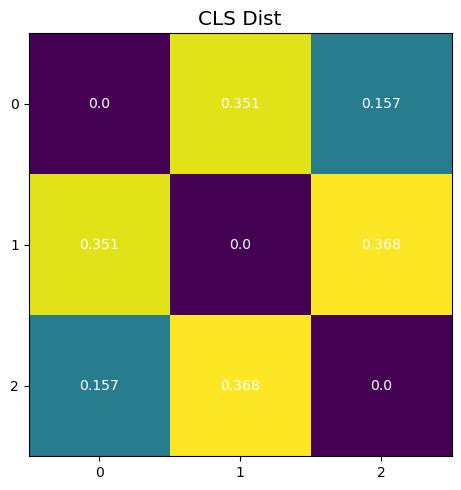

In [70]:
def gen_CLS_similarity(model_output):        
    token_embeddings = model_output.last_hidden_state

    # Note that the `[CLS]` token is the first one in the sentence's encoding.
    CLSs = token_embeddings[:, 0, :]

    # Normalize along dim=1 Which is the Token-axis.
    # This is a L_p norm https://en.wikipedia.org/wiki/Lp_space. With p=2, it becomes the 
    # standard Euceldian norm (Sqrt of sum of squares)
    normalized = F.normalize(CLSs, p=2, dim=1)    
    return pairwise_cosine_distance(normalized)

cls_similarity_dist = gen_CLS_similarity(model_output)
visualize([cls_similarity_dist], titles=["CLS Dist"])


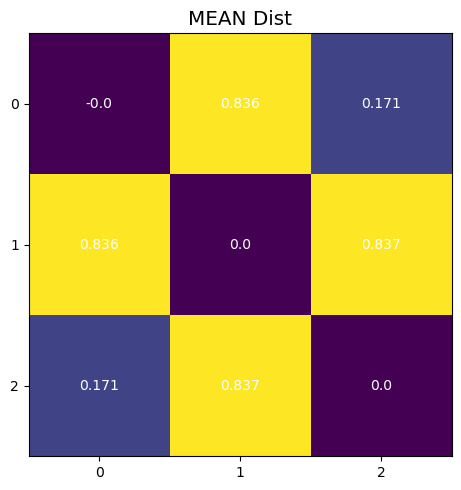

In [39]:
# Compute the mean similarity distance
# Use the mean of the vectors across all tokens of a sentence
def gen_mean_similarity(model_output):
    token_embeddings = model_output.last_hidden_state

    # Take the mean along the tokens dimension.
    # each token index points to a vector so the mean is also a vector (element-wize adds)
    # Likely to be the same as HF's mean pooling
    MEANS = token_embeddings.mean(dim=1)

    # Normalize along dim=1 Which is the Token-axis.
    # This is a L_p norm https://en.wikipedia.org/wiki/Lp_space. With p=2, it becomes the 
    # standard Euceldian norm (Sqrt of sum of squares)
    normalized = F.normalize(MEANS, p=2, dim=1)

    return pairwise_cosine_distance(normalized)

mean_similarity_dist = gen_mean_similarity(model_output)
visualize([mean_similarity_dist], titles=["MEAN Dist"])

[[1.         0.16433036 0.829093  ]
 [0.16433036 1.0000001  0.16265826]
 [0.829093   0.16265826 1.0000001 ]]


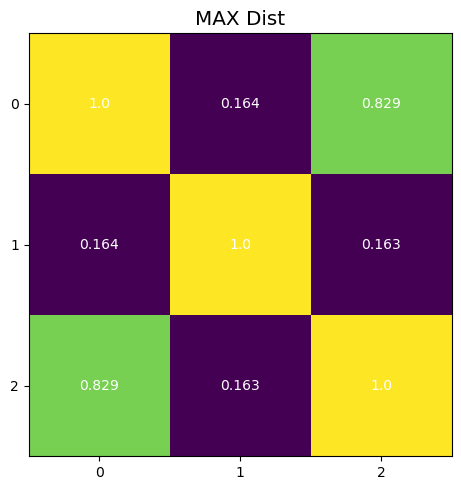

In [73]:
# max-over-time, refers to the max element across the vectors along each of the dimensions
def gen_max_similarity(model_output):
    token_embeddings = model_output.last_hidden_state

    # Take the mean along the tokens dimension.
    # each token index points to a vector so the mean is also a vector (element-wize adds)
    # Likely to be the same as HF's mean pooling
    MAXS, _ = token_embeddings.max(dim=1)

    # Normalize along dim=1 Which is the Token-axis.
    # This is a L_p norm https://en.wikipedia.org/wiki/Lp_space. With p=2, it becomes the 
    # standard Euceldian norm (Sqrt of sum of squares)
    normalized = F.normalize(MAXS, p=2, dim=1)    
    return pairwise_cosine_similarity(normalized)

max_similarity_dist = gen_mean_similarity(model_output)
visualize([max_similarity_dist], titles=["MAX Dist"])

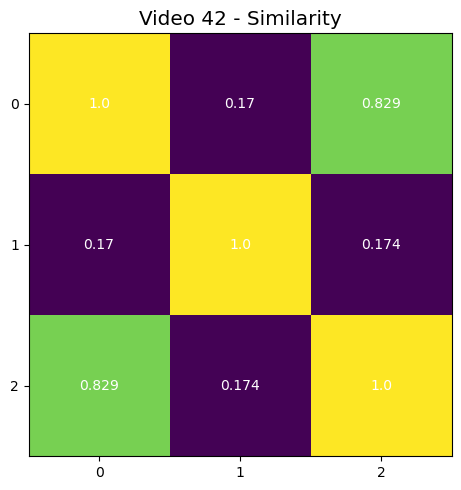

In [75]:
# Now generate the similarity from the video lesson
# https://www.youtube.com/watch?v=OATCgQtNX2o&list=PLo2EIpI_JMQvWfQndUesu0nPBAtZ9gP1o&index=42
#
# Note that sentence_embeddings has already been normalized
# ✔️ I get the same plot the lesson shows (Timestamp 2.10/3.29)
sentence_similarity = pairwise_cosine_similarity(sentence_embeddings)
visualize([sentence_similarity], titles=["Video 42 - Similarity"])

# Semantic Search

Given that we are dealing with embeddings, search is like nearest-neighbors with cosine-similarity as the metric. 


In [78]:
from datasets import load_dataset

# Just load the last 100 from validation set.
squad = load_dataset("squad", split="validation[:100]")

def get_embeddings(text_list):
    encoded_input = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt")    

    # What does this do ? Move data into the GPU ?
    # these are { "attention_mask" : tensor, etc..}
    encoded_input = {k: v.to("cuda") for k,v in encoded_input.items()}

    with torch.no_grad():
        model_output = model(**encoded_input)
    
    return mean_pooling(model_output, encoded_input["attention_mask"])

# What is going on here ?
# What is x ?
# This errors out with "Expected all tensors on the same device but found at least two devices, cpu and cuda:0!"
# Deal with this later!!
squad_with_embeddings = squad.map(
    lambda x: {"embeddings": get_embeddings(x["context"]).detach().cpu().numpy()[0]}
)

# This special "faiss" thing allows for quick searches. Need details.
#squad_with_embeddings.add_faiss_index(column = "embeddings")

#question = "Who headlined the halftime show for Super Bowl 50?"
#question_embedding = get_embeddings([question]).detach().cpu().numpy()
#question_embedding.shape()

# Ok so this FAISS thing builds some vector db like index for "embeddings"
# ahead of time instead of doing it on demand. Is it ?
#scores, samples = squad_with_embeddings.get_nearest_examples(
    #"embeddings", question_embedding, k=3
#)

Found cached dataset parquet (/home/vamsi/.cache/huggingface/datasets/parquet/plain_text-b38df7ca980d7b55/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)



# Deeper dive into BERT

[Why BERT has 3 embedding layers and their implementation details](https://medium.com/@_init_/why-bert-has-3-embedding-layers-and-their-implementation-details-9c261108e28a). Following are my notes from this link.

> Unlike other DL layers, BERT has three different embedding layers: Token, Segment and Position embedding. While exactly what makes an embedding layer is still not clear to me, token embedding seems clear enough. Focusing on the other two.
![](./img/bert-embedding-layers.webp)

## Token Embedding

 The role of this layer is to transform words into vector rep of fixed dimensions. For BERT this is a 768-dimensional vector.

 ![](./img/bert-token-embedding-inputs.webp)
  - The embedding table is stored in the model (_generated during training_)
  - BERT gets away with a vocabulary of 30,522 (_hence the dimension of the matrix_) with 768 long vector for each vocabulary token. _No info how the 30k size came about. Iteratively increasing it till they hit diminishing returns ?_
  - Uses WordPiece tokenization.
  - 👉 Each token gets converted to a 768 long vector


## Segment Embedding

Turns out to be far simpler than it sounds. Likely has some roots in efficient processing.

![](./img/bert-segment-embedding-inputs.webp)
 - Simply to distinguish one segment from the other
 - Since one of BERT's objectives is NSP (_Next sentence prediction_), this is limited to `size(2, 768)`
 - If there are two inputs (NSP): First sentence gets index(0)'s vector and second gets index(1)'s vector
 - If there is only one input (MSM): The sentence gets index(0)'s vector

## Position embedding

 Transformers do not generally encode the position of their input tokens. There is [some history](https://medium.com/@_init_/how-self-attention-with-relative-position-representations-works-28173b8c245a) here: the example below explains the motivation clearly though.

 When processing `I think, therefore I am`, _the first "I" should not have the same vector representation as the second "I"_. Wow, seems like such wishful, curious to see how they achieved this via a new embedding layer. Max sentence length constraint ? ✔️.

 BERT was designed to learn representations of sentences with a max-length of 512. This means that each token could have a different rep based on which position it falls in (_also contexted with attention layers I'd assume_). So I would say:`[30522 x 512 x 768]`.

 I would be wrong. Apprently this is a `(512 x 768)` sized matrix!! Ah, these are simply markers 💡
  - 👉 **All** first words have a representation at index - 0. All second words at index-1 and so on for 512 possible words/tokens.
  - Comparing "Hello world" and "Hi There". Both 'Hello' and 'Hi' will have the same representation since it simply encodes the index in the segment.

## Combining the representation

Given a sequence of length `n` (_tokens_), we will have three embeddings. _When using sentence pairs, change 1 to 2_
 - Token embeddings of size `(1, n, 768)` which simply embed the tokens
   - _These are backed by a `(30522, 768)` matrix which maps each token_
 - Segment embeddings with shape `(1, n ,768)` which help BERT distinguish between paired input sequences
   - _These are backed by a shape `(2, 768)` which mark a token as belonging to the first or second input_
 - Positional embeddings with shape `(1, n, 768)` to let BERT know that the inputs it is being fed have a temporal property.
   - _These are backed by a `(512, 768)` which encode each position in the max-length of the input_

 Since these are all of the same shape. They are simply summed for each input. The paper says that this summed input `(1, n, 768)` is what is passed to BERT's Encoder layer!! So all the neural learning happens earlier ? The following image makes much more sense now!

![](./img/bert-embedding-layers.webp)

## Aside

 One of the papers linked [Machine translation - Wu Et. Al.](https://arxiv.org/pdf/1609.08144.pdf) shows the name of one of my kid's friend's dad! How cool!

